## **TODO**:

- check again the code
- Run all the cells 1 time
- delete this cell

# Machine Learning LAB 1 
Course 2023/24: P. Zanuttigh, M. Caligiuri, F. Lincetto

The notebook contains some simple tasks to be performed about **classification and regression**. <br>
Complete all the **required code sections** and **answer to all the questions**. <br>

### IMPORTANT for the evaluation score:
1. **Read carefully all cells** and **follow the instructions**.
1. **Rerun all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
2. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
3. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command** - otherwise points will be deduced.
4. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

##  Classification of Stayed/Churned Customers

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB1.ipynb** otherwise your homework could get lost
<br>

**Student name**: Gabriele Bertinelli<br>
**ID Number**: 2103359

### Dataset description

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. 
The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

<center>

![COVER](data/dataset-cover.png "COVER")

</center>

We first **import** all **the packages** that are needed.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing

Change some global settings for layout purposes.

In [2]:
# if you are in the jupyter notebook environment you can change the 'inline' option with 'notebook' to get interactive plots
%matplotlib inline
# change the limit on the line length and crop to 0 very small numbers, for clearer printing
np.set_printoptions(linewidth=500, suppress=True)

## A) Perceptron
In the following cells we will **implement** the **perceptron** algorithm and use it to learn a halfspace.

**TO DO (A.0):** **Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [3]:
IDnumber = 2103359 # YOUR_ID
np.random.seed(IDnumber)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (the **training** set is **typically larger**, here we use a 75% training 25% test split).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above. Try different seeds to evaluate the impact of randomization.<br><br>
**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [4]:
def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

In [5]:
# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

# Split data in training and test sets



Given $m$ total data, denote with $m_{t}$ the part used for training. Keep $m_t$ data as training data, and $m_{test}:= m-m_{t}$. <br>
For instance one can take $m_t=0.75m$ of the data as training and $m_{test}=0.25m$ as testing. <br>
Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

TESTING DATA: The test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

**TO DO (A.1):** **Divide** the **data into training and test set** (**75%** of the data in the **first** set, **25%** in the **second** one). <br>
<br>
Notice that as is common practice in Statistics and Machine Learning, **we scale the data** (= each variable) so that it is centered **(zero mean)** and has **standard deviation equal to 1**. <br>
This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [6]:
# compute the splits
m_training = int(0.75*len(X))

# m_test is the number of samples in the test set (total-training)
m_test =  len(X)-m_training

# X_training = instances for training set
X_training =  X[:m_training]
# Y_training = labels for the training set
Y_training =  Y[:m_training]

# X_test = instances for test set
X_test = X[m_training:]
# Y_test = labels for the test set
Y_test =  Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940

Number of night instances in test: 451
Number of day instances in test: 489
Mean of the training input data: [-0. -0.  0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [-0.00367513  0.0024175   0.04891114]
Std of the test input data: [0.97988081 1.01714166 1.01938255]


We **add a 1 in front of each sample** so that we can use a vector in **homogeneous coordinates** to describe all the coefficients of the model. This can be done with the function $hstack$ in $numpy$.

In [7]:
def to_homogeneous(X_training, X_test):
    # Add a 1 to each sample (homogeneous coordinates)
    X_training = np.hstack( [np.ones( (X_training.shape[0], 1) ), X_training] )
    X_test = np.hstack( [np.ones( (X_test.shape[0], 1) ), X_test] )
    
    return X_training, X_test

In [8]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.         -1.18373721 -0.55719872 -1.61111528]
 [ 1.         -1.18373721  0.78474667 -0.01896538]
 [ 1.          0.18710224  1.26221788 -0.54968201]
 [ 1.         -1.18373721  0.26539203 -0.37277647]
 [ 1.         -0.72679073 -1.59925869  0.57071977]
 [ 1.         -1.18373721  0.13806637 -0.31380795]
 [ 1.         -0.80987191  0.91877368 -0.78555607]
 [ 1.          0.22864283  0.63731697 -0.9034931 ]
 [ 1.          1.43331992  1.46493373 -0.37277647]
 [ 1.          0.27018341 -1.6042847  -0.01896538]]


**TO DO (A.2):** Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout .

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [9]:
def count_errors(current_w, X, Y):
    # This function:
    # computes the number of misclassified samples
    # returns the index of all misclassified samples
    # if there are no misclassified samples, returns -1 as index
  
    pred = np.sign(np.dot(X, current_w))                 # pred must have the same shape as Y, hint: pred = np.sign( ... )
    wrong = (pred != Y)                # wrong has the same shape as pred and Y, contains boolean values
    num_misclassified = wrong.sum()             # num_misclassified contains the number of wrong predictions
    
    if num_misclassified > 0:
        index_misclassified = np.where(wrong)[0][0]
    else:
        index_misclassified = -1 # signaling value for termination
    
    return num_misclassified, index_misclassified
        
def perceptron_update(current_w, x, y):
    # Place in this function the update rule of the perceptron algorithm
    # Remember that numpy arrays can be treated as generalized variables
    # therefore given array a = [1,2,3,4], the operation b = 10*a will yield
    # b = [10, 20, 30, 40]
    new_w = current_w + y*x
    return new_w

def perceptron_no_randomization(X, Y, max_num_iterations):
    
    # Initialize some support variables
    num_samples = X.shape[0]
    # best_errors will keep track of the best (minimum) number of errors
    # seen throughout training, used for the update of the best_w variable
    best_error = num_samples+1
    
    # Initialize the weights of the algorith with w=0
    curr_w = np.zeros(X.shape[1])
    # The best_w variable will be used to keep track of the best solution
    best_w = curr_w.copy()

    # compute the number of misclassified samples and the index of the first of them
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified
        best_w = curr_w.copy()
    
    # initialize the number of iterations
    num_iter = 0
    # Main loop continue until all samples correctly classified or max # iterations reached
    # Remember that to signify that no errors were found we set index_misclassified = -1

    while index_misclassified != -1 and num_iter < max_num_iterations:
    # Call the perceptron_update function using the found misclassified sample
        curr_w = perceptron_update(curr_w, X[index_misclassified], Y[index_misclassified])
        
        # repeat the error count and best variables update
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified
            best_w = curr_w.copy()
        
        # update the iteration number
        num_iter += 1

    # as required, return the best error as a ratio with respect to the total number of samples
    best_error = best_error / num_samples
    
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 30 iterations and print the error of the best model we have found.

In [10]:
# Now run the perceptron for 30 iterations
w_found_nr, error_nr = perceptron_no_randomization(X_training, Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error_nr))

Training Error of perceptron (30 iterations): 0.30067447639332623


**TO DO (A.3):** use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [11]:
errors_nr, _ = count_errors(w_found_nr, X_test, Y_test)

true_loss_estimate_nr = errors_nr / X_test.shape[0] # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate_nr))

Test Error of perceptron (30 iterations): 0.33085106382978724


In [12]:
# check how training error evolves with the number of iterations
a_nr = []
b_nr = []

for j in range (1, 1500, 10):
    w_found_nrj, error_nrj = perceptron_no_randomization(X_training, Y_training, j)
    a_nr.append(error_nrj)

    errors_nrj, _ = count_errors(w_found_nrj, X_test, Y_test)
    test_err_nrj = errors_nrj /X_test.shape[0]
    b_nr.append(test_err_nrj)

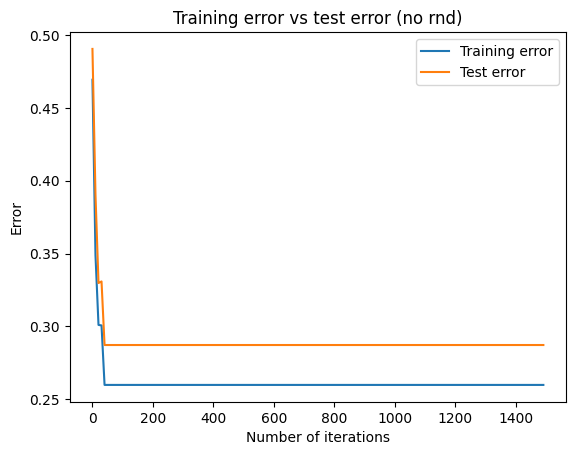

In [13]:
plt.plot(range(1, 1500, 10), a_nr, label='Training error')
plt.plot(range(1, 1500, 10), b_nr, label='Test error')

plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.title('Training error vs test error (no rnd)')
plt.legend()

**TO DO (A.4):** implement the correct randomized version of the perceptron such that at each iteration the algorithm picks a random misclassified sample and updates the weights using that sample.

In [24]:
def perceptron(X, Y, max_num_iterations):
    num_samples = X.shape[0]
    best_error = num_samples+1
    curr_w = np.zeros(X.shape[1])
    best_w = curr_w.copy()

    # compute the number of misclassified samples and the index of the first of them
    # num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    # # update the 'best' variables
    # if num_misclassified < best_error:
    #     best_error = num_misclassified
    #     best_w = curr_w.copy()
    
    # initialize the number of iterations
    num_iter = 0

    while num_iter < max_num_iterations:
        # Call the perceptron_update function using the found misclassified sample
        # curr_w = perceptron_update(curr_w, X[index_misclassified], Y[index_misclassified])
        
        per = np.random.permutation(num_samples)
        X = X[per]
        Y = Y[per]

        mis_indx = np.where(np.sign(np.dot(X, curr_w))!=Y)[0]
        if len(mis_indx) == 0:
            break

        index_misclassified = np.random.choice(mis_indx)

        # Call the perceptron_update function using the found misclassified sample
        curr_w = perceptron_update(curr_w, X[index_misclassified], Y[index_misclassified])

        # repeat the error count and best variables update
        num_misclassified, _ = count_errors(curr_w, X, Y)
        
        
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified
            best_w = curr_w.copy()
        
        # update the iteration number
        num_iter += 1

    # as required, return the best error as a ratio with respect to the total number of samples
    best_error = best_error / num_samples
    
    return best_w, best_error



**TO DO (A.5):** Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [25]:
# Now run the perceptron for 30 iterations
w_found_r, error_r = perceptron(X_training, Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error_r))

errors_r, _ = count_errors(w_found_r, X_test,Y_test)

true_loss_estimate_r = errors_r/X_test.shape[0]     # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate_r))

Training Error of perceptron (30 iterations): 0.24955626553070642
Test Error of perceptron (30 iterations): 0.2712765957446808


In [26]:
# check how training error evolves with the number of iterations
a_r = []
b_r = []

for j in range (1, 1500, 10):
    w_found_rj, error_rj = perceptron(X_training, Y_training, j)
    a_r.append(error_rj)

    errors_rj, _ = count_errors(w_found_rj, X_test, Y_test)
    test_err_rj = errors_rj /X_test.shape[0]
    b_r.append(test_err_rj)

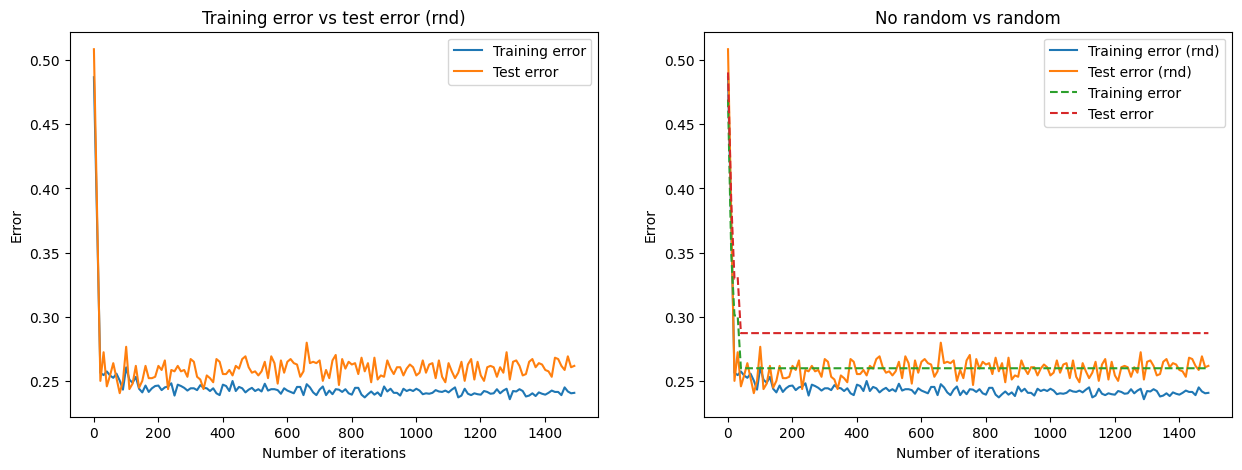

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

ax[0].plot(range(1, 1500, 10), a_r, label='Training error')
ax[0].plot(range(1, 1500, 10), b_r, label='Test error')

ax[0].set_xlabel('Number of iterations')
ax[0].set_ylabel('Error')
ax[0].set_title('Training error vs test error (rnd)')
ax[0].legend()

ax[1].plot(range(1, 1500, 10), a_r, label='Training error (rnd)')
ax[1].plot(range(1, 1500, 10), b_r, label='Test error (rnd)')
ax[1].plot(range(1, 1500, 10), a_nr, '--', label='Training error')
ax[1].plot(range(1, 1500, 10), b_nr, '--', label='Test error')

ax[1].set_xlabel('Number of iterations')
ax[1].set_ylabel('Error')
ax[1].set_title('No random vs random')
ax[1].legend()

**TO DO (A.Q1) [Answer the following]** <br>
What is the difference between the two versions of the perceptron? Can you explain why there is this difference? <br>

<div class="alert alert-block alert-info">
**ANSWER A.Q1**:<br>
The first thing one can notice is that the non-randomized perceptron training/test errors have few to no fluctuations, while the errors of the correct perceptron model shows lots of fluctuation (while staying more or less constant). Furthermore, the correct perceptron errors are lower by ~5% wrt the ones of the non-randomized model.

Randomization is the key to break biases that can be present in the data, for example if they are ordered or grouped in a certain way. Randomizing ensures that the model is exposed to all types of data. This helps prevent the model from learning the specific order or patterns in the data and makes the learning process more robust (lowering the error).
 </div>

### Now consider only a the random version of the perceptron

**TO DO (A.Q2) [Answer the following]** <br>
What about the difference between the training error and the test error  in terms of fraction of misclassified samples? Explain what you observe. (Notice that with a very small dataset like this one results can change due to randomization, try to run with different random seeds if you get unexpected results).

<div class="alert alert-block alert-info">
**ANSWER A.Q2**:<br>
The training error is typically lower than the test error because the model is trained on the training data (i.e. it's "optimized" to perform well on this data).  
The goal of a good ML model is to generalize well from the training data to unseen data (i.e. test data). A model that performs well both on training data and test data is likely a good model. In our case, the two errors are comparable (1-2% in difference), so the model is performing good.  
Instead, if the training error had been much lower than the test error it meant that the model had overfitted.
 </div>

**TO DO (A.6):** Copy the code from the last 2 cells above in the cell below and repeat the training with 3000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [28]:
# Now run the perceptron for 3000 iterations
w_found_r, error_r = perceptron(X_training, Y_training, 3000)
print("Training Error of perceptron (3000 iterations): " + str(error_r))

errors_r, _ = count_errors(w_found_r, X_test,Y_test)

true_loss_estimate_r = errors_r/X_test.shape[0]     # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (3000 iterations): " + str(true_loss_estimate_r))

Training Error of perceptron (3000 iterations): 0.23997160099396522
Test Error of perceptron (3000 iterations): 0.26170212765957446


**TO DO (A.Q3) [Answer the following]** <br>
What about the difference between the training error and the test error in terms of the fraction of misclassified samples) when running for a larger number of iterations? Explain what you observe and compare with the previous case.

<div class="alert alert-block alert-info">
**ANSWER A.Q3**:<br>
As you can see from the plot above, after ~300 iterations the training error stabilizes around 24% with very little fluctuations around this value. While, the test error have bigger fluctuations (+- ~1%/~2%) around 25%. The model, with both 30 iterations and 3000, is quite stable and performs well.
</div>

# B) Logistic Regression
Now we use **logistic regression**, exploiting the implementation in **Scikit-learn**, to predict labels. We will also plot the decision boundaries of logistic regression.

We first load the dataset again.

To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. <br>
See the Scikit-learn documentation for how to use it [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**TO DO (B.1):** **Define** the **logistic regression** model, then **learn** the model using **the training set** and **predict** on the **test set**. Then **print** the **fraction of samples misclassified** in the training set and in the test set.

In [29]:
# part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5)

# learn from training set: hint use fit(...)
logreg.fit(X_training, Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training)

# print the error rate = fraction of misclassified samples
error_count_training_3 = (predicted_training != Y_training).sum()
error_rate_training_3 = error_count_training_3 / X_training.shape[0]
print("Error rate on training set: "+str(error_rate_training_3))

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test_3 = (predicted_test != Y_test).sum()
error_rate_test_3 = error_count_test_3 / X_test.shape[0]
print("Error rate on test set: " + str(error_rate_test_3))

Intercept: [-0.0713378]
Coefficients: [[-0.07133779 -1.49343055  0.85704925  0.22194306]]
Error rate on training set: 0.23997160099396522
Error rate on test set: 0.25638297872340426


**TO DO (B.2)** Now **pick two features** and restrict the dataset to include only two features, whose indices are specified in the $idx0$ and $idx1$ variables below. Then split into training and test.

In [30]:
# features correlation for employees who left
df_x = pd.DataFrame(X[Y==1])
df_x.corr()

,0,1,2
0,1.000000,0.388136,0.063403
1,0.388136,1.000000,0.099795
2,0.063403,0.099795,1.000000


In [31]:
# features correlation for employees who stayed
df_x = pd.DataFrame(X[Y==-1])
df_x.corr()

,0,1,2
0,1.000000,0.273168,0.029768
1,0.273168,1.000000,0.113489
2,0.029768,0.113489,1.000000


In [32]:
feature_names  = ["Tenure in Months","Monthly Charge","Age"]

# Select the two features to use
idx0 = 1
idx1 = 2

X_reduced = X[:,[idx0, idx1]]

# re-initialize the dataset splits, with the reduced sets
X_training = X_reduced[:m_training]
Y_training = Y[:m_training]

X_test = X_reduced[m_training:]
Y_test = Y[m_training:]

# print(len(X_training), len(Y_training))
# print(len(X_test), len(Y_test))

Now learn a model using the training data and measure the performances.

In [33]:
# learning from training data
logreg.fit(X_training, Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test_2 = (predicted_test != Y_test).sum()

# print the error rate = fraction of misclassified samples
error_rate_test_2 = error_count_test_2 / X_test.shape[0]
print("Error rate on test set: " + str(error_rate_test_2))

Intercept: [-1.46351425]
Coefficients: [[0.01215928 0.01267059]]
Error rate on test set: 0.4021276595744681


**TO DO (B.Q1) [Answer the following]** <br>
Which features did you select and why? <br>
Compare the perfomance of the classifiers trained with every combination of two features with that of the baseline (which used all 3 features).

<div class="alert alert-block alert-info">
**ANSWER B.Q1**:<br>
In principle, there is no reason why one should choose two features instead of two others. For this reason, I looked at the correlation matrix of employees who left and stayed. In both cases the two features with the highest correlation are "Tenure in Month" and "Monthly Charge". Choosing these two features there's a better chance that the model makes the correct prediction. However this is not true in general, because using two highly correlated features for a regression model can lead to problems known as multicollinearity (e.g. the model becomes more sensitive to slight changes). On the other hand, if two features are not correlated at all, it might mean they provide unique information for predicting the target, which could potentially improve your model's performance.
In absence of way to do features selection I chose "Monthly Charge" and "Age", whose correlation is in the middle. The error is pretty high: ~40%. So probably they are not the best couple.

We can see that, with all 3 models, the couple of features with minimum training/test error is 'Tenure in Months, Monthly Charge'.

In the case of non-randomized perceptron 'Tenure in Months, Monthly Charge' and 'Tenure in Months, Age' have a lower error wrt the model trained with all 3 features. 

In the case of randomized perceptron, the error from the model trained with all the features is slightly lower than the one from the model trained just with 'Tenure in Months, Monthly Charge'.

In the case of LogisticRegression the error with all the features and the one with 'Tenure in Months, Monthly Charge' is ~ the same.

From the plots we can see that the randomized perceptron and the LogisticRegression have similar error in all the cases. So, since the LogisticRegression class is correct and optimized by expert, we can conclude that the randomized perceptron model is built in the correct way.
</div>

In [132]:
import pandas as pd

# Define the classifiers
classifiers = {
    "perceptron_no_randomization": perceptron_no_randomization,
    "perceptron": perceptron,
    "LogisticRegression": LogisticRegression
}

# Define the feature pairs
feature_pairs = [(0, 1), (0, 2), (1, 2)]

# Create a DataFrame to store the errors
errors_df = pd.DataFrame(columns=["Classifier", "Feature_Pair", "Training_Error", "Test_Error"])

# For each classifier
for classifier_name, classifier in classifiers.items():
    
    # For each pair of features
    for idx0, idx1 in feature_pairs:
        
        # Select the two features to use
        X_reduced = X[:, [idx0, idx1]]

        # Re-initialize the dataset splits, with the reduced sets
        X_training = X_reduced[:m_training]
        Y_training = Y[:m_training]

        X_test = X_reduced[m_training:]
        Y_test = Y[m_training:]

        # Train the classifier
        if classifier_name in ["perceptron_no_randomization", "perceptron"]:
            w_found, training_error = classifier(X_training, Y_training, 50)

            # Compute the test error
            errors, _ = count_errors(w_found, X_test, Y_test)
            test_error = errors / len(X_test)
        else:
            model = classifier(C=10e5).fit(X_training, Y_training)
            training_error = 1 - model.score(X_training, Y_training)

            test_error = 1 - model.score(X_test, Y_test)

        # Append the errors to the DataFrame
        
        temp_df = pd.DataFrame({
            "Classifier": [classifier_name],
            "Feature_Pair": [f"{feature_names[idx0]}, {feature_names[idx1]}"],
            "Training_Error": [training_error],
            "Test_Error": [test_error]
        })

        errors_df = pd.concat([errors_df, temp_df], ignore_index=True)

feat_df = pd.DataFrame({
            "Classifier": ['perc_nr', 'perc_r', 'logreg'],
            "Feature_Pair": ["3_features", "3_features", "3_features"],
            "Training_Error": [error_nr, error_r, error_rate_training_3],
            "Test_Error": [true_loss_estimate_nr, true_loss_estimate_r, error_rate_test_3]
        })

errors_df = pd.concat([errors_df, feat_df], ignore_index=True)

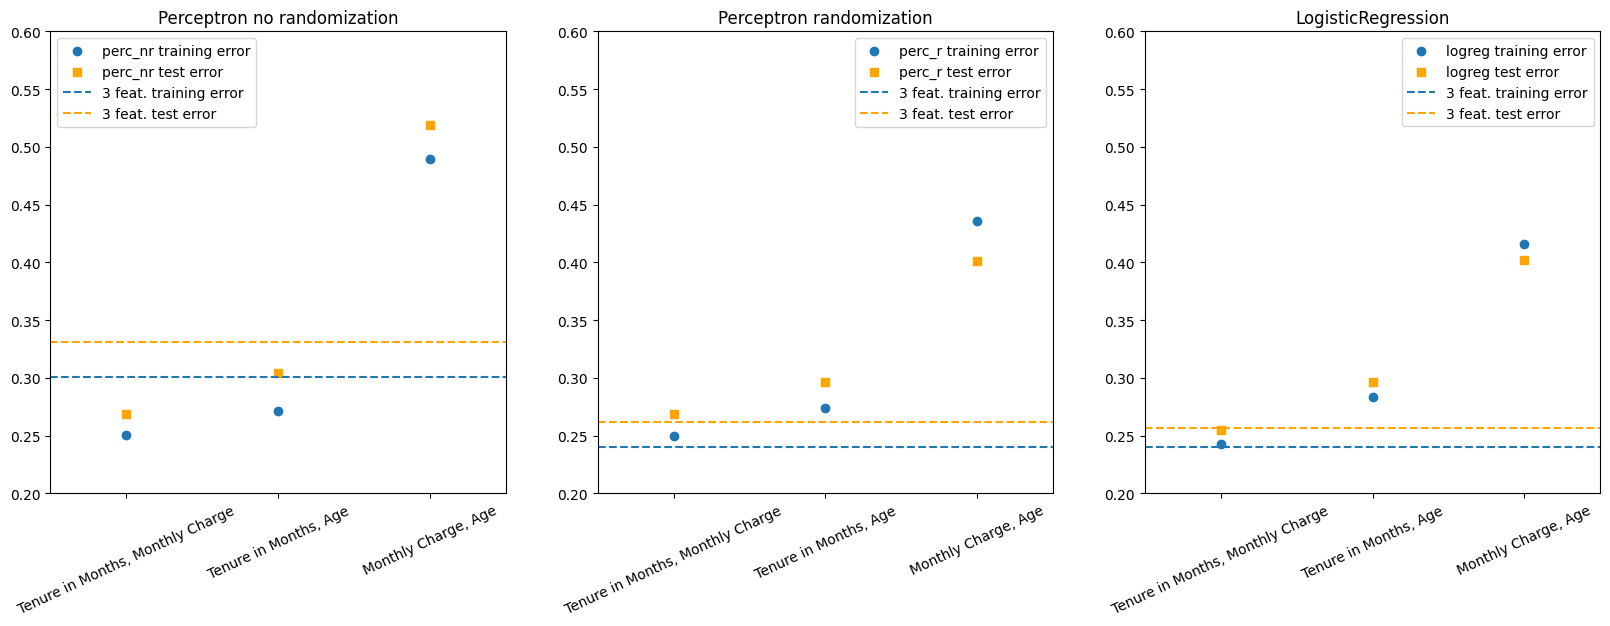

In [172]:
perc_nr = errors_df[errors_df['Classifier'] == 'perceptron_no_randomization']
perc_r = errors_df[errors_df['Classifier'] == 'perceptron']
logreg = errors_df[errors_df['Classifier'] == 'LogisticRegression']
feat_3 = errors_df[errors_df['Feature_Pair'] == '3_features']

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))

ax[0].scatter(x=range(3), y=perc_nr['Training_Error'], label='perc_nr training error')
ax[0].scatter(x=range(3), y=perc_nr['Test_Error'], label='perc_nr test error', color='orange', marker=',')
ax[0].hlines(feat_3[feat_3["Classifier"] == "perc_nr"]['Training_Error'], xmin=-0.5, xmax=3.5, label='3 feat. training error', linestyles='--')
ax[0].hlines(feat_3[feat_3["Classifier"] == "perc_nr"]['Test_Error'], xmin=-0.5, xmax=3.5, label='3 feat. test error', linestyles='--', color='orange')
ax[0].set_xlim(-0.5, 2.5)
ax[0].set_ylim(0.20, 0.6)
ax[0].legend()
ax[0].set_title('Perceptron no randomization')
ax[0].set_xticks(range(3), errors_df[errors_df['Feature_Pair'] != "3_features"]["Feature_Pair"].unique(), rotation=25)

ax[1].scatter(x=range(3), y=perc_r['Training_Error'], label='perc_r training error')
ax[1].scatter(x=range(3), y=perc_r['Test_Error'], label='perc_r test error', color='orange', marker=',')
ax[1].hlines(feat_3[feat_3["Classifier"] == "perc_r"]['Training_Error'], xmin=-0.5, xmax=3.5, label='3 feat. training error', linestyles='--')
ax[1].hlines(feat_3[feat_3["Classifier"] == "perc_r"]['Test_Error'], xmin=-0.5, xmax=3.5, label='3 feat. test error', linestyles='--', color='orange')
ax[1].set_xlim(-0.5, 2.5)
ax[1].set_ylim(0.20, 0.6)
ax[1].legend()
ax[1].set_title('Perceptron randomization')
ax[1].set_xticks(range(3), errors_df[errors_df['Feature_Pair'] != "3_features"]["Feature_Pair"].unique(), rotation=25)

ax[2].scatter(x=range(3), y=logreg['Training_Error'], label='logreg training error')
ax[2].scatter(x=range(3), y=logreg['Test_Error'], label='logreg test error', color='orange', marker=',')
ax[2].hlines(feat_3[feat_3["Classifier"] == "logreg"]['Training_Error'], xmin=-0.5, xmax=3.5, label='3 feat. training error', linestyles='--')
ax[2].hlines(feat_3[feat_3["Classifier"] == "logreg"]['Test_Error'], xmin=-0.5, xmax=3.5, label='3 feat. test error', linestyles='--', color='orange')
ax[2].set_xlim(-0.5, 2.5)
ax[2].set_ylim(0.20, 0.6)
ax[2].legend()
ax[2].set_title('LogisticRegression')
ax[2].set_xticks(range(3), errors_df[errors_df['Feature_Pair'] != "3_features"]["Feature_Pair"].unique(), rotation=25)
